In [34]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## Loading the data (MNIST)

In [5]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [6]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 60000


In [7]:
train_target[0].type()

'torch.cuda.LongTensor'

In [8]:
test_input.shape

torch.Size([10000, 1, 28, 28])

In [9]:
train_input = train_input[0:10000]
train_target = train_target[0:10000]

test_input = test_input[0:10000]
test_target = test_target[0:10000]

In [10]:
computeClassesWeights(train_target)

tensor([0.1001, 0.1127, 0.0991, 0.1032, 0.0980, 0.0863, 0.1014, 0.1070, 0.0944,
        0.0978])

In [11]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset

In [12]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [13]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00928573           0.703      0.00002344           0.930
10                   0.00017335           0.995      0.00000601           0.981
20                   0.00001535           1.000      0.00000510           0.985
30                   0.00000683           1.000      0.00000524           0.986
40                   0.00000417           1.000      0.00000546           0.986
49                   0.00000309           1.000      0.00000565           0.985
*******************************************************************************


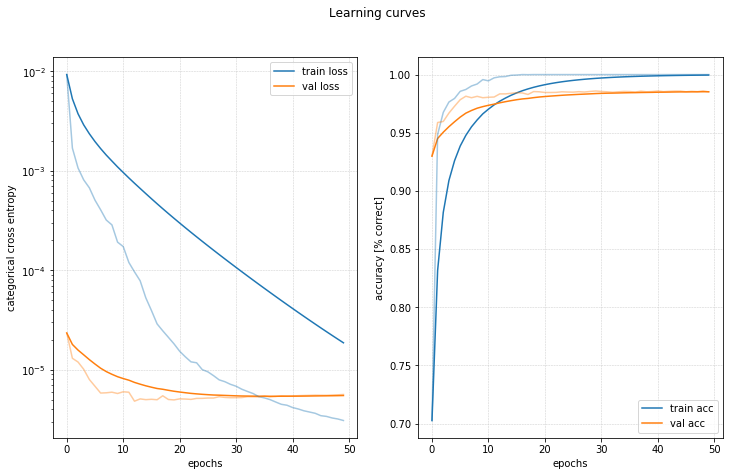

In [14]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 60
batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [72]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [73]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [74]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -1.1261,   0.2319,  -2.2108,   8.2289,  -8.8106,  13.9956,  -5.1217,
          -4.9852,   4.3573,  -1.5158],
        [ 16.1048,  -5.2382,   1.3853,  -3.6267,  -7.9822,   2.5762,   1.2530,
           1.2929,  -5.4332,   3.9208],
        [ -6.9658,  -0.2990,   3.6982,   1.3166,  12.7887,  -3.0896,  -2.0600,
           2.0811,  -5.5891,   3.5318],
        [ -4.2202,  16.6430,   5.7847,  -4.7326,  -0.7825,  -9.9602,  -1.6584,
           4.1487,   3.8827,  -6.1504],
        [ -7.4407,  -1.0903,  -3.7515,  -1.2637,   7.1777,  -2.8158,  -7.9753,
           2.3371,   5.4118,  16.4798],
        [  1.9087,  -3.1865,  11.0889,   2.2133,  -8.3201,  -1.6184,  -2.6984,
           0.3635,   4.1818,   1.9694],
        [ -7.7393,  11.7036,   2.5693,  -0.2030,  -0.7769,  -1.3100,   0.1971,
           0.0766,   3.9108,  -2.7437],
        [ -0.8917,  -4.6641,   4.4691,  19.9583, -11.5973,   3.9280, -12.2253,
          -2.5459,   6.0714,   3.7880],
        [ -6.5266,  11.3777,   0.5818,  -2.0877,

In [75]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [76]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [40]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [41]:
layer = model.fc1
layer_name = "fc1"

In [42]:
g_train_target.type()

'torch.cuda.LongTensor'

In [43]:
g_train_dataset, g_test_dataset = \
generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7) 

In [44]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of layer vector :", size_input_vector)

size of layer vector : 200


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00232312           0.530      0.00011987           0.420
10                   0.00216346           0.627      0.00014783           0.414
20                   0.00204004           0.662      0.00014100           0.447
30                   0.00192363           0.688      0.00015610           0.449
40                   0.00178490           0.717      0.00016725           0.455
49                   0.00168092           0.740      0.00020964           0.457
*******************************************************************************


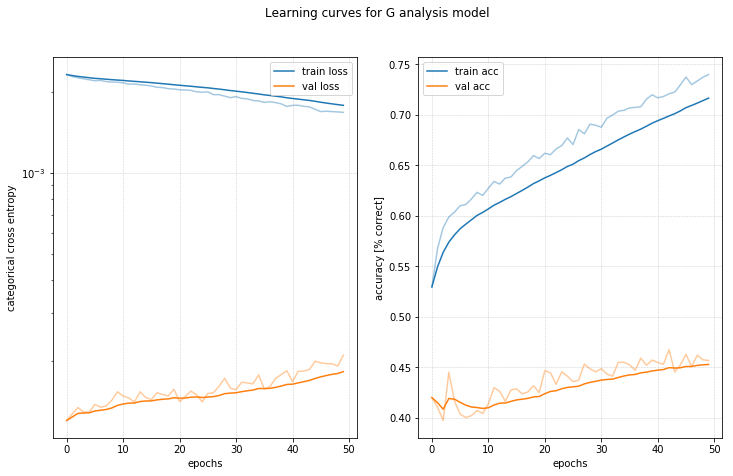

In [19]:
modelG = aliGs(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()
learning_rate = 0.01

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=50, batch_size=500, verbose=10)
mt.plot_training("Learning curves for G analysis model")

## 4) Train 10 shadow F models

In [45]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [46]:
train_step = train_dataset[0].shape[0]//10
test_step = test_dataset[0].shape[0]//10

In [47]:
shadow_train_inputs = list()
shadow_train_targets = list()
shadow_test_inputs = list()
shadow_test_targets = list()

shadow_train_datasets = list()
shadow_test_datasets = list()

for i in range(10):
    shadow_train_inputs.append(train_dataset[0][i*train_step:(i+1)*train_step])
    shadow_train_targets.append(train_dataset[1][i*train_step:(i+1)*train_step])
    shadow_train_datasets.append((shadow_train_inputs[i], shadow_train_targets[i]))
    
    shadow_test_inputs.append(test_dataset[0][i*test_step:(i+1)*test_step])
    shadow_test_targets.append(test_dataset[1][i*test_step:(i+1)*test_step])
    shadow_test_datasets.append((shadow_test_inputs[i], shadow_test_targets[i]))


training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


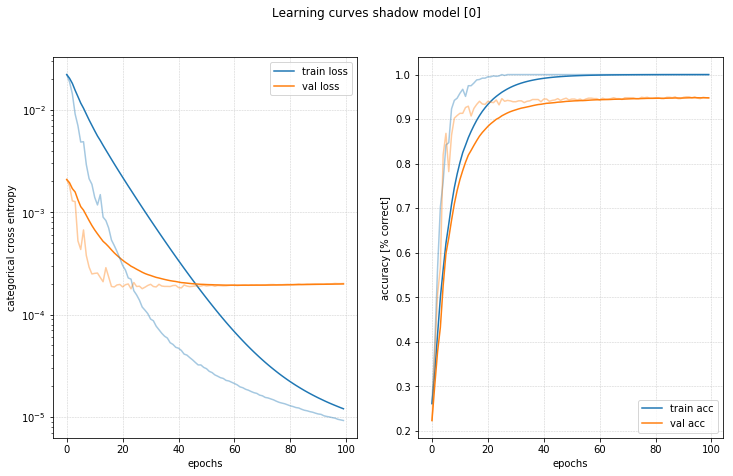

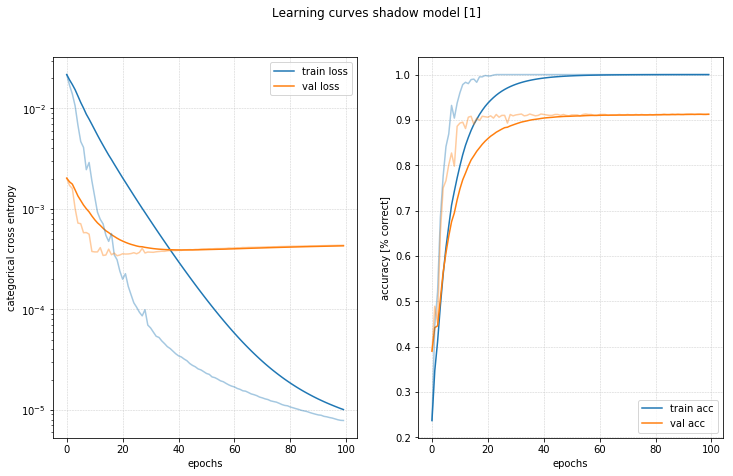

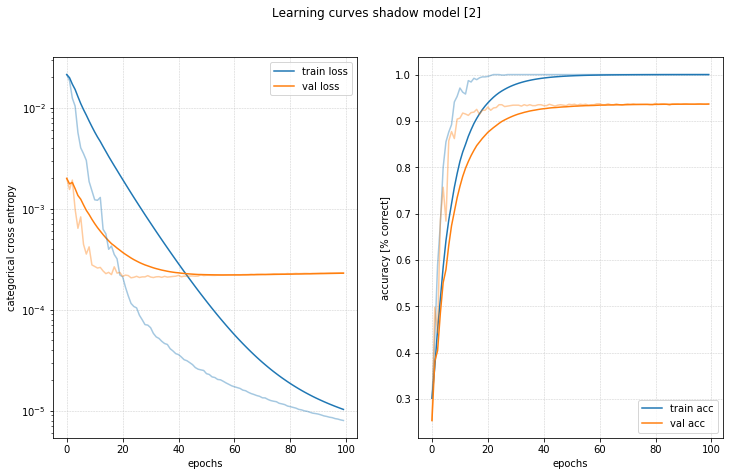

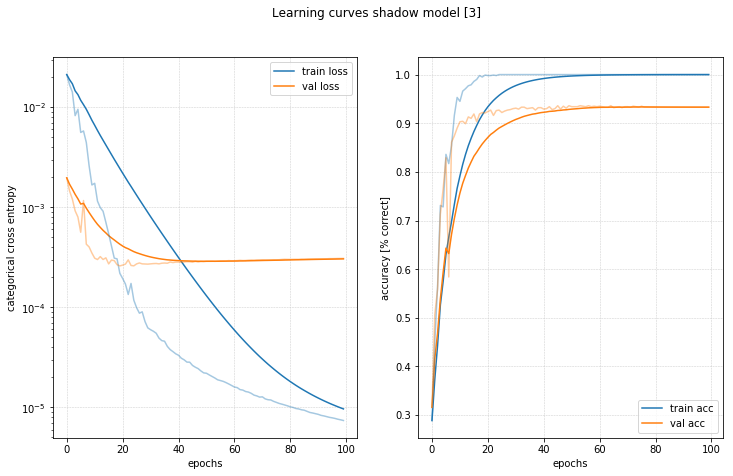

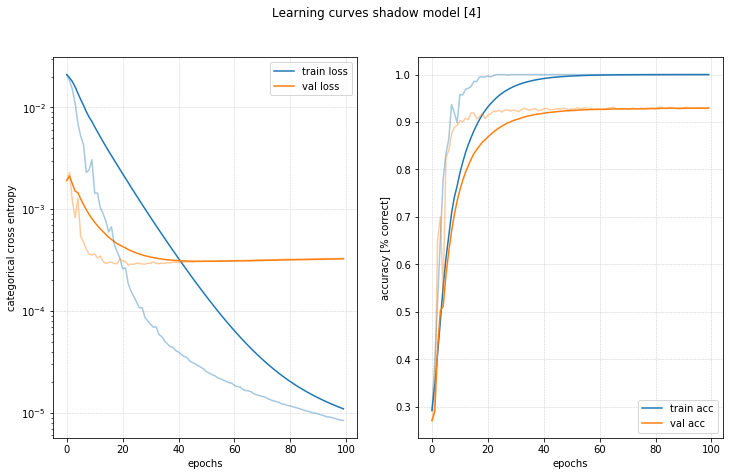

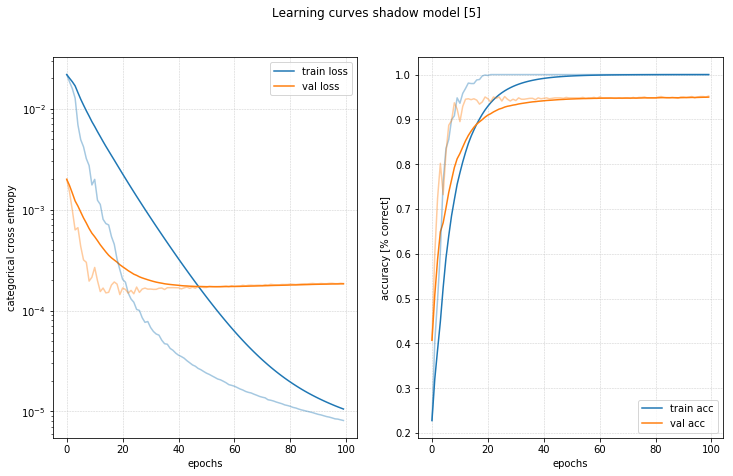

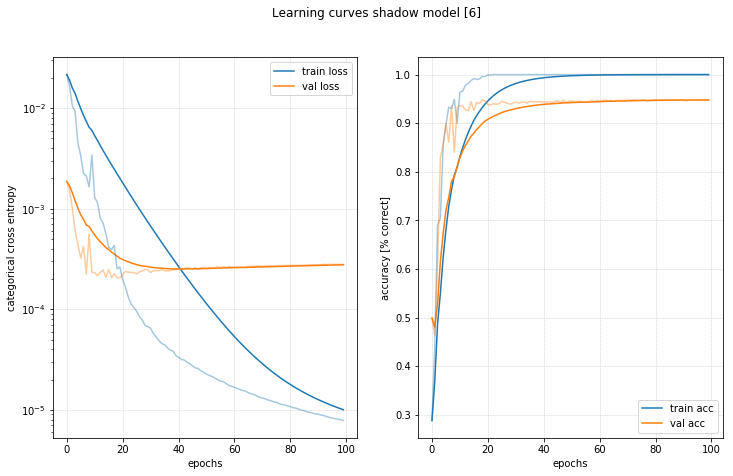

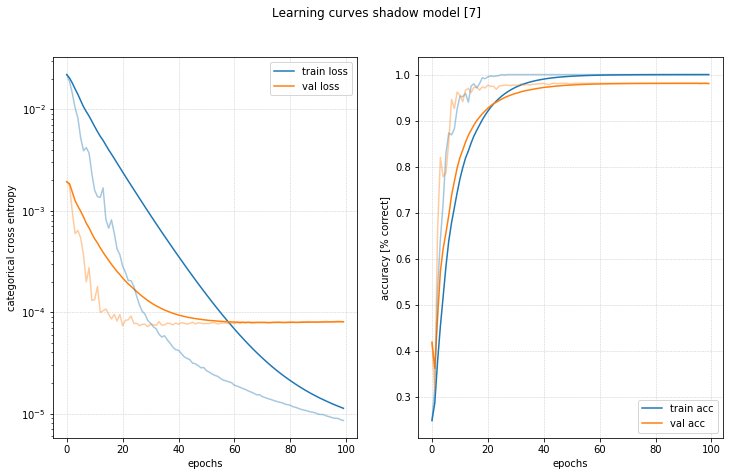

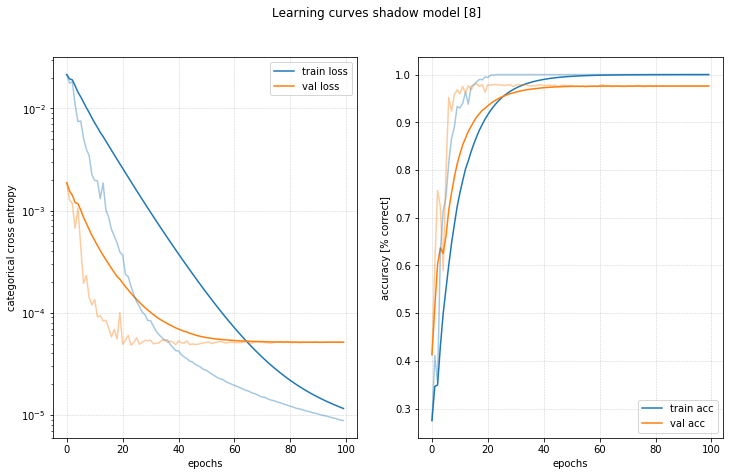

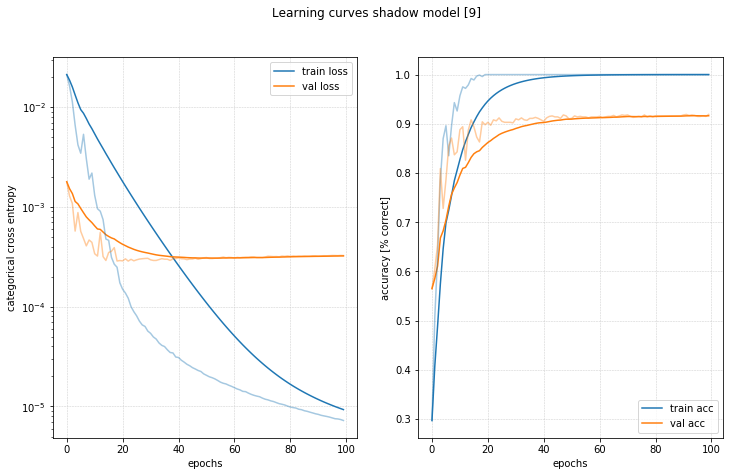

In [48]:
model_class = LeNet
models = list()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 100
batch_size = 100
verbose = 0

for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')
    models.append(model_class())
    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(models[i], loss_fun, optim.SGD(models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")

In [49]:
for i in range(10):
    models[i].eval()

In [61]:
shadow_layers = list()
shadow_layers_names = list()
for i in range(10):
    shadow_layers.append(models[i].conv2)
    shadow_layers_names.append("shadow model ["+str(i)+"] layer conv2")

In [62]:
split = 0.7

shadow_g_train_input = train_input.new()
shadow_g_train_target = train_target.new()
shadow_g_test_input = test_input.new()
shadow_g_test_target = test_target.new()

for i in range(10):
    (tmp_g_train_input, tmp_g_train_target), (tmp_g_test_input, tmp_g_test_target) = \
    generate_dataset_g(models[i], shadow_train_datasets[i], shadow_test_datasets[i], [shadow_layers[i]], [shadow_layers_names[i]], split=split)
    
    shadow_g_train_input = torch.cat((shadow_g_train_input,tmp_g_train_input))
    shadow_g_train_target = torch.cat((shadow_g_train_target,tmp_g_train_target))
    
    shadow_g_test_input = torch.cat((shadow_g_test_input,tmp_g_test_input))
    shadow_g_test_target = torch.cat((shadow_g_test_target,tmp_g_test_target))
    
shadow_g_train_dataset = (shadow_g_train_input, shadow_g_train_target)
shadow_g_test_dataset = (shadow_g_test_input, shadow_g_test_target)

In [63]:
shadow_g_train_input.shape

torch.Size([14000, 1, 1024])

In [71]:
unique_classes = torch.unique(shadow_g_train_target)

In [78]:
shadow_g_train_input[shadow_g_train_target == 1].shape

torch.Size([7000, 1, 1024])